#Cuaderno 2 - Miércoles - Grupo 4: Filtro de realce de color R, G o B

##Introducción

En este cuaderno se intentará demostrar el potencial de procesamiento que nos provee la GPU en comparación a la CPU. Por tal motivo, desarrollamos un filtro propio que consiste en detectar los píxeles de color rojo, verde o azul y realzarlos (según elección del usario) mientras que el resto de los píxeles son convertidos a escala de grises.
<br>
El algoritmo funciona de la siguiente manera: Supongamos que el usuario eligió el color rojo. El algoritmo recorrerá todos los píxeles de la imagen y por cada pixel analizará si la componente "R" es mayor a 100 y si las componentes "G" y "B" son menores a 120. Éstos datos surgen de una investigación propia en la que se hicieron muestreos de varias imágenes y se analizaron las componentes R, G y B para obtener los valores de umbral.<br><br>
<table><tr><td><img src="https://i.ibb.co/7C1HFPb/rgb1.png"></td>
<td><img src="https://i.ibb.co/mTvf8Lz/rgb2.png"></td>
</tr><tr><td><img src="https://i.ibb.co/HP9fQ4c/rgb3.png"></td></tr></table>

*Valores RGB obtenidos al analizar imágenes.*

<br>Siguiendo el ejemplo, si el pixel analizado corresponde a la gama del color rojo, se procede a realzar el color. Ésto se hace aumentando la componente R en un 25% y disminuyendo las componentes G y B en un 30%. Si el pixel analizado no corresponde a la gama del color rojo, entonces se transforma a escala de grises de la siguiente manera [2]: Se multiplica la componente roja por 0.3, la componente verde por 0.59 y la componente azul por 0.11, luego se suman esos valores y el resultado obtenido será el valor de las commponentes R, G y B del píxel en escala de grises.

##Armado del ambiente

Debido a que vamos a ejecutar código tanto en CPU como en GPU, necesitamos tener unas consideraciones previas.

1. Primero que nada hay que habilitar el entorno GPU.

  Para esto hay que ir a **Entorno de ejecución > Cambiar tipo de entorno de ejecución**. <br>Seleccionar GPU como *acelerador de hardware* y luego guardar.
2. Luego debemos instalar **OpenCL [2]** ya que vamos a trabajar con ésta biblioteca.
  <br>Para ello debemos ejecutar la siguiente instrucción:

In [ ]:
!pip install pyopencl

     |████████████████████████████████| 880kB 28.3MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=22b179bf2193133925832f2a2e3739874d34996562b347fbfec39a844852561b
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


Definimos una función lambda para mostrar las métricas de tiempos.

In [21]:
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

##Desarrollo CPU

**Imágenes propuestas:**<br>
<br>**Bombonera**<br>
https://as01.epimg.net/argentina/imagenes/2021/05/25/futbol/1621973866_916305_1621974052_noticia_normal_recorte1.jpg
<br>**Estrellas (Pequeña):**<br>
https://i.ibb.co/rygm5Nt/stars.png
<br>**Salzburgo (Grande):**<br>
https://press-music.com/wp-content/uploads/2019/12/Festung_Salzach.jpg


--2021-06-27 16:47:33--  https://as01.epimg.net/argentina/imagenes/2021/05/25/futbol/1621973866_916305_1621974052_noticia_normal_recorte1.jpg
Resolving as01.epimg.net (as01.epimg.net)... 199.232.194.133, 199.232.198.133
Connecting to as01.epimg.net (as01.epimg.net)|199.232.194.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91447 (89K) [image/jpeg]
Saving to: ‘imagen_usuario’

imagen_usuario      100%[===================>]  89.30K  --.-KB/s    in 0.002s  

2021-06-27 16:47:33 (51.1 MB/s) - ‘imagen_usuario’ saved [91447/91447]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


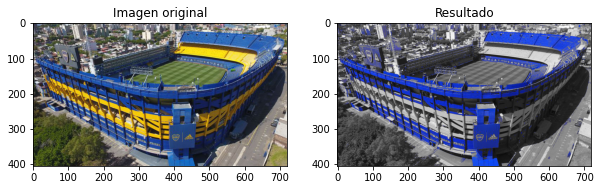

In [86]:
#@title Filtro para realzar color RGB

#@markdown Ingrese la URL de la imagen que desea procesar: 

url_de_la_imagen = "https://as01.epimg.net/argentina/imagenes/2021/05/25/futbol/1621973866_916305_1621974052_noticia_normal_recorte1.jpg" #@param {type: "string"}

if not (type(url_de_la_imagen) is str) or (url_de_la_imagen == ""):
  raise TypeError("URL inválida")

!wget {url_de_la_imagen} -O imagen_usuario


#@markdown Seleccionar el color que desea realzar:
 
Color = "Azul" #@param ["Rojo", "Verde", "Azul"]
#@markdown ---
#---------------------------------------------------------------------------------------

#Importamos los módulos
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
%matplotlib inline

# Tiempo total de ejecución
tiempo_cpu_total = datetime.now()

try:
  imagen = Image.open('imagen_usuario')
except:
  raise Exception("No se pudo abrir la imagen")

#Obtenemos las dimensiones de la imagen
img_ancho, img_alto = imagen.size

#Convertimos la imagen en un array
img_O_cpu = np.asarray(imagen).astype(np.int32)
img_R_cpu = np.empty_like( img_O_cpu)

#Defino las funciones de realce

def realzar_rojo():
  for y in range(0, img_alto):
    for x in range(0, img_ancho):
      pixel_R, pixel_G, pixel_B = img_O_cpu[y][x]
      if pixel_R>100 and pixel_G<120 and pixel_B <120:
        img_R_cpu[y][x] = [pixel_R*1.25, pixel_G*0.7, pixel_B*0.7]
      else:
        escala_de_grises = pixel_R*0.3 + pixel_G*0.59 + pixel_B * 0.11
        img_R_cpu[y][x] = [escala_de_grises,escala_de_grises,escala_de_grises]

def realzar_verde():
  for y in range(0, img_alto):
    for x in range(0, img_ancho):
      pixel_R, pixel_G, pixel_B = img_O_cpu[y][x]
      if pixel_R<120 and pixel_G>100 and pixel_B <120:
        img_R_cpu[y][x] = [pixel_R*0.7, pixel_G*1.25, pixel_B*0.7]
      else:
        escala_de_grises = pixel_R*0.3 + pixel_G*0.59 + pixel_B * 0.11
        img_R_cpu[y][x] = [escala_de_grises,escala_de_grises,escala_de_grises]

def realzar_azul():
  for y in range(0, img_alto):
    for x in range(0, img_ancho):
      pixel_R, pixel_G, pixel_B = img_O_cpu[y][x]
      if pixel_R<120 and pixel_G<120 and pixel_B >100:
        img_R_cpu[y][x] = [pixel_R*0.7, pixel_G*0.7, pixel_B*1.25]
      else:
        escala_de_grises = pixel_R*0.3 + pixel_G*0.59 + pixel_B * 0.11
        img_R_cpu[y][x] = [escala_de_grises,escala_de_grises,escala_de_grises]


if Color is "Rojo":
  tiempo_cpu = datetime.now()
  realzar_rojo()
if Color is "Verde":
  tiempo_cpu = datetime.now()
  realzar_verde()
if Color is "Azul":
  tiempo_cpu = datetime.now()
  realzar_azul()
# Obtengo la diferencia para saber cuanto tiempo transcurrió
tiempo_cpu = datetime.now() - tiempo_cpu

#Mostramos las imagenes
f = plt.figure(figsize=(10,15))
f.add_subplot(1,2,1)
plt.imshow(imagen)
plt.title("Imagen original")
f.add_subplot(1, 2, 2)
plt.title("Resultado")
plt.imshow(img_R_cpu)
tiempo_cpu_total = datetime.now() - tiempo_cpu_total

##Desarrollo GPU

Para el desarrollo en GPU, primero ejecutamos el código que genera el Kernel necesario para la aplicación de los filtros.

In [68]:
codigo = """
const sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | 
						  CLK_ADDRESS_CLAMP_TO_EDGE | 
						  CLK_FILTER_NEAREST;

//Lo que hacemos con estos filtros es detectar si la componente R, G o B del pixel es superior a 100 y las otras inferiores a 120. Si esa condición se cumple, significa que ese píxel es de tono rojo, azul o verde (según corresponda).
//Si pasa el filtro, realzamos la componente un 25% y reducimos el resto de las componentes del pixel un 30%.
//Si no pasa el filtro, convertimos el pixel a escala de grises.

__kernel void realzar_color_rojo(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
  int ancho_imagen = *img_ancho;
  int alto_imagen = *img_alto;
  int2 coordenadas = (int2) (get_global_id(0), get_global_id(1));
  
    if (coordenadas.x < ancho_imagen && coordenadas.y < alto_imagen)  
    {
      uint4 pixel = read_imageui(original, sampler, coordenadas);
      if(pixel.x>100 && pixel.y<120 && pixel.z<120){
        pixel.x = pixel.x*1.25;
        pixel.y = pixel.y*0.7;
        pixel.z = pixel.z*0.7;
      } else{
        float escala_de_grises = 0.3 * pixel.x + 0.59 * pixel.y + 0.11 * pixel.z;
        pixel.x = pixel.y = pixel.z = escala_de_grises;
      }
      

      write_imageui(resultado, coordenadas, pixel);
    }
}

__kernel void realzar_color_verde(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
  int ancho_imagen = *img_ancho;
  int alto_imagen = *img_alto;
  int2 coordenadas = (int2) (get_global_id(0), get_global_id(1));
  
    if (coordenadas.x < ancho_imagen && coordenadas.y < alto_imagen)  
    {
      uint4 pixel = read_imageui(original, sampler, coordenadas);
      if(pixel.y>100 && pixel.x<120 && pixel.z<120){
        pixel.x = pixel.x*0.7;
        pixel.y = pixel.y*1.25;
        pixel.z = pixel.z*0.7;
      } else{
        float escala_de_grises = 0.2126 * pixel.x + 0.7152 * pixel.y + 0.0722 * pixel.z;
        pixel.x = pixel.y = pixel.z = escala_de_grises;
      }
      

      write_imageui(resultado, coordenadas, pixel);
    }
}

__kernel void realzar_color_azul(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
  int ancho_imagen = *img_ancho;
  int alto_imagen = *img_alto;
  int2 coordenadas = (int2) (get_global_id(0), get_global_id(1));
  
    if (coordenadas.x < ancho_imagen && coordenadas.y < alto_imagen)  
    {
      uint4 pixel = read_imageui(original, sampler, coordenadas);
      if(pixel.x<120 && pixel.y<120 && pixel.z>100){
        pixel.x = pixel.x*0.7;
        pixel.y = pixel.y*0.7;
        pixel.z = pixel.z*1.25;
      } else{
        float escala_de_grises = 0.2126 * pixel.x + 0.7152 * pixel.y + 0.0722 * pixel.z;
        pixel.x = pixel.y = pixel.z = escala_de_grises;
      }
      

      write_imageui(resultado, coordenadas, pixel);
    }
}

"""
text_file = open("kernel.cl", "w")
text_file.write(codigo)
text_file.close()


Luego ejecutamos el código

**Imágenes propuestas:**<br>
<br>**Bombonera**<br>
https://as01.epimg.net/argentina/imagenes/2021/05/25/futbol/1621973866_916305_1621974052_noticia_normal_recorte1.jpg
<br>**Estrellas (Pequeña):**<br>
https://i.ibb.co/rygm5Nt/stars.png
<br>**Salzburgo (Grande):**<br>
https://press-music.com/wp-content/uploads/2019/12/Festung_Salzach.jpg


--2021-06-27 16:47:47--  https://as01.epimg.net/argentina/imagenes/2021/05/25/futbol/1621973866_916305_1621974052_noticia_normal_recorte1.jpg
Resolving as01.epimg.net (as01.epimg.net)... 199.232.194.133, 199.232.198.133
Connecting to as01.epimg.net (as01.epimg.net)|199.232.194.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91447 (89K) [image/jpeg]
Saving to: ‘imagen_usuario’

imagen_usuario      100%[===================>]  89.30K  --.-KB/s    in 0.003s  

2021-06-27 16:47:47 (28.2 MB/s) - ‘imagen_usuario’ saved [91447/91447]



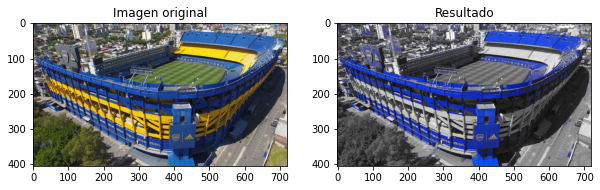

In [87]:
#@title Filtro para realzar color RGB

#@markdown Ingrese la URL de la imagen que desea procesar: 

url_de_la_imagen = "https://as01.epimg.net/argentina/imagenes/2021/05/25/futbol/1621973866_916305_1621974052_noticia_normal_recorte1.jpg" #@param {type: "string"}

if not (type(url_de_la_imagen) is str) or (url_de_la_imagen == ""):
  raise TypeError("URL inválida")

!wget {url_de_la_imagen} -O imagen_usuario


#@markdown Seleccionar el color que desea realzar:
 
Color = "Azul" #@param ["Rojo", "Verde", "Azul"]
#@markdown ---
#---------------------------------------------------------------------------------------

#Importamos los módulos
import numpy as np
import matplotlib.pyplot as plt
import pyopencl as cl
from PIL import Image
from datetime import datetime
%matplotlib inline

# Tiempo en CPU + GPU
tiempo_gpu_total = datetime.now()


#Configuramos OpenCL
contexto = cl.create_some_context()
cola = cl.CommandQueue(contexto)


#Pasamos la imagen subida a formato RGBA
try:
  imagen = Image.open('imagen_usuario')
  if imagen.mode != "RGBA":
    imagen = imagen.convert("RGBA")
except:
  raise Exception("No se pudo abrir la imagen")

#Obtenemos las dimensiones de la imagen
ancho, alto = imagen.size

#Convertimos la imagen en un array
img_array = np.asarray(imagen).astype(np.int32)

#Creamos los buffers para las imagenes
formato = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNSIGNED_INT8)
#Creamos los buffers para la imagen original y el resultado
img_original = cl.Image(contexto, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, formato, imagen.size, None, imagen.tobytes())
img_resultado = cl.Image(contexto, cl.mem_flags.WRITE_ONLY, formato, imagen.size)

#Creamos los buffers para las variables que pasamos como parámetros
ancho_gpu = cl.Buffer(contexto, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(ancho))
alto_gpu = cl.Buffer(contexto, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(alto))


#Abrimos el archivo "kernel.cl" para poder ejecutarlo
try:
  kernel = open("kernel.cl", "r")
except:
  raise Exception("No se encontró el archivo 'kernel.cl'.")

programa = cl.Program(contexto, kernel.read()).build()

#Dependiendo el color seleccionado, se llama a la función correspondiente
if Color is "Rojo":
    # Obtenemos el tiempo actual antes de la ejecución
    tiempo_gpu = datetime.now()
    evento = programa.realzar_color_rojo(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)
if Color is "Verde":
    # Obtenemos el tiempo actual antes de la ejecución
    tiempo_gpu = datetime.now()
    evento = programa.realzar_color_verde(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)
if Color is "Azul":
    # Obtenemos el tiempo actual antes de la ejecución
    tiempo_gpu = datetime.now()
    evento = programa.realzar_color_azul(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)

# Obtenemos la diferencia de tiempo para saber cuanto tiempo estuvo ejecutando
tiempo_gpu = datetime.now() - tiempo_gpu

#Copiamos el resultado desde la GPU
resultado = np.empty_like(imagen)
cl.enqueue_copy(cola, resultado, img_resultado, origin=(0,0,0), region=(ancho, alto, 1), wait_for=[evento])

#Limpiamos
img_original.release()
img_resultado.release()
ancho_gpu.release()
alto_gpu.release()
cola.flush()
cola.finish()

#Mostramos las imagenes
f = plt.figure(figsize=(10,15))
f.add_subplot(1,2,1)
plt.imshow(imagen)
plt.title("Imagen original")
f.add_subplot(1, 2, 2)
plt.title("Resultado")
plt.imshow(resultado)

#Calculo los tiempos de ejecucion totales
tiempo_gpu_total = datetime.now() - tiempo_gpu_total
tempo_gpu_gpu_total=tiempo_gpu_total - tiempo_gpu
tiempo_gpu_total_string=str(tiempo_en_ms(tiempo_gpu_total))
tiempo_gpu_gpu_total_string=str(tiempo_en_ms(tempo_gpu_gpu_total))


##Métricas

In [88]:
print (' _________________________________________________________')
print ("|{:<15}|{:<20}|{:<20}|".format('Tiempos','Implementación CPU','Implementación GPU'))
print ('|---------------|--------------------|--------------------|')
print ("|{:<15}|{:>20}|{:>20}|".format('Tiempo CPU', str(tiempo_en_ms(tiempo_cpu)) + 'ms', tiempo_gpu_gpu_total_string + 'ms'))
print ("|{:<15}|{:>20}|{:>20}|".format('Tiempo GPU','0.0ms', str(tiempo_en_ms(tiempo_gpu)) + 'ms'))
print ("|{:<15}|{:>20}|{:>20}|".format('Tiempo Total',  str(tiempo_en_ms(tiempo_cpu_total)) + 'ms', tiempo_gpu_total_string + 'ms'))
print ('|_______________|____________________|____________________|')

 _________________________________________________________
|Tiempos        |Implementación CPU  |Implementación GPU  |
|---------------|--------------------|--------------------|
|Tiempo CPU     |          3617.422ms|            222.31ms|
|Tiempo GPU     |               0.0ms|            35.969ms|
|Tiempo Total   |          3674.834ms|           258.279ms|
|_______________|____________________|____________________|


##Conclusiones

A partir de los resultados obtenidos en las métricas, se ve que el tiempo de ejecución total del programa utilizando la GPU para la imagen propuesta es de tan sólo el 7.02% del tiempo de ejecución total utilizando sólo la CPU. Es decir, aproximadamente 14 veces menos. Ésto nos da una clara demostración de la mejora en tiempo que nos proveen los threads.
<br>
Similar a lo concluído en el ejercicio 1, si se trata de imágenes pequeñas, por ejemplo una imagen de 256x256 píxeles, la diferencia entre ambos algoritmos será despreciable, ya que el overhead de la planificación de threads termina equiparando los tiempos totales. Para la imagen propuesta (Estrellas) se obtuvieron los siguientes tiempos:
CPU: 270.92ms, GPU: 238.978ms
<br>
**Pero también es importante destacar que cuanto mayor es la imagen, mayor también será la brecha entre ambos.** Para una imagen de 1851x1041 píxeles, la diferencia es casi 100 veces menor para el algoritmo con GPU. Para la imagen propuesta (Salzburgo) se obtuvieron los siguientes tiempos:
CPU: 23335.426ms, GPU: 365.318ms

##Bibliografía
[1] Síntesis digital de color utilizando tonos de gris, Ing. Jesús Gustavo Flores Eraña [PDF](https://ninive.uaslp.mx/xmlui/bitstream/handle/i/2264/MCA1SDC00901.pdf?sequence=1&isAllowed=y://)
<br>
[2] Documentación Oficial de OpenCL: [Web](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/) 